<a href="https://colab.research.google.com/github/ykjoy/mining/blob/main/classification_dt_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 분류 (Classification)   

분류는 미리 정의된 여러 클래스 레이블 (Label) 중 하나를 예측하는 것으로, 2개의 클래스로 분류하는 이진 분류(binary classification)와 3개 이상의 클래스로 분류하는 다중 분류(multi class)로 나뉨

의사결정나무(Decision tree) 모델을 이용하여 암 진단(양성과 악성)의 분류 문제를 해결해 보자. 
- 데이터 탐색 
- 의사결정나무 모델 
- 앙상블 모델 (랜덤포레스트, 그래디언트 부스팅)      

*본 실습은 파이썬 라이브러리를 활용한 머신러닝 (A.Mueller & S.Guido, 박해선 역, 한빛미디어, 2019) 교재 참고


In [ ]:
# 간단하게 그림을 그릴 수 있는 mglearn 라이브러리 사용 (!pip install mglearn 명령어로 설치)
# !pip install mglearn 

In [ ]:
!pip install --upgrade joblib==1.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import mglearn

## 데이터 탐색

위스콘신대에서 제공하는 암진단 데이터를 탐색해 보자. 

- 스노우보드에서 wisc_bc_data.csv 화일을 다운로드 받아 Google Drive의 My Drive/Colab Notebooks/ITB 폴더에 올리기 
- scikit-learn의 load_breast_cancer 함수를 이용하여 직접 받을 수도 있다.
- https://www.kaggle.com/uciml/breast-cancer-wisconsin-data
- 분석에 사용할 데이터 정보
 * id : 환자 아이디
 * diagnosis : 타겟 변수 (2개의 class)
    * M (malignant 악성)
    * B (benign 양성)
 * 세포에 관한 30개 변수 
    * radius, texture, preimeter, area, smoothness, compactness, concavity, points, symmetry, dimension, _mean(평균), _se(표준편차), _worst(가장 큰 값 3개의 평균)    

구글 드라이브의 화일을 이용하기 위해서는 아래 코드를 실행시켜 구글 드라이브와 연동시켜야 한다. 

- 코드를 실행시켜 아래 링크를 클릭한 후, 구글 계정을 선택, 허용을 누르면 코드가 뜨게 된다.  
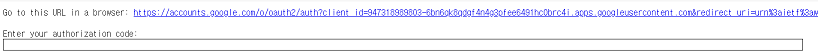
- 이 코드를 복사하여 애플리케이션으로 전환한 다음 붙여넣으면 된다. 해당 코드를 그대로 복사하여 "Enter your authorization code" 부분에 붙여넣고 enter를 눌러주세요.  
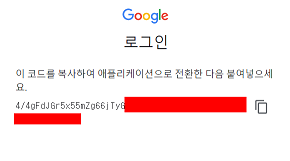

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
import pandas as pd
import seaborn as sns           # Seaborn 로딩하기
import matplotlib.pyplot as plt # Matplotlib의 pyplot 로딩하기

In [ ]:
# csv 데이터 가져오기, id를 인덱스로 지정
wisc = pd.read_csv("/content/drive/My Drive/Colab Notebooks/ITB/wisc_bc_data.csv", index_col='id')

print(wisc.columns)
display(wisc.info())      # 569행의 데이터 - id는 index이므로 생략됨, diagnosis와 30개 변수 (결측치 없음)  
display(wisc.head())      # 처음 5행 확인

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'points_mean', 'symmetry_mean', 'dimension_mean', 'radius_se',
       'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'points_se', 'symmetry_se',
       'dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst',
       'area_worst', 'smoothness_worst', 'compactness_worst',
       'concavity_worst', 'points_worst', 'symmetry_worst', 'dimension_worst'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 87139402 to 9012795
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   diagnosis          569 non-null    object 
 1   radius_mean        569 non-null    float64
 2   texture_mean       569 non-null    float64
 3   perimeter_mean     569 non-null    float64
 4   ar

None

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,points_worst,symmetry_worst,dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
87139402,B,12.32,12.39,78.85,464.1,0.10280,0.06981,0.03987,0.03700,0.1959,...,13.50,15.64,86.97,549.1,0.1385,0.1266,0.12420,0.09391,0.2827,0.06771
8910251,B,10.60,18.95,69.28,346.4,0.09688,0.11470,0.06387,0.02642,0.1922,...,11.88,22.94,78.28,424.8,0.1213,0.2515,0.19160,0.07926,0.2940,0.07587
905520,B,11.04,16.83,70.92,373.2,0.10770,0.07804,0.03046,0.02480,0.1714,...,12.41,26.44,79.93,471.4,0.1369,0.1482,0.10670,0.07431,0.2998,0.07881
868871,B,11.28,13.39,73.00,384.8,0.11640,0.11360,0.04635,0.04796,0.1771,...,11.92,15.77,76.53,434.0,0.1367,0.1822,0.08669,0.08611,0.2102,0.06784
9012568,B,15.19,13.21,97.65,711.8,0.07963,0.06934,0.03393,0.02657,0.1721,...,16.20,15.73,104.50,819.1,0.1126,0.1737,0.13620,0.08178,0.2487,0.06766


In [ ]:
wisc.describe()  # id는 인덱스로 지정되어 있으므로 id를 제외한 변수들의 기술통계 정보를 보여줌 

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,points_mean,symmetry_mean,dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,points_worst,symmetry_worst,dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


B    357
M    212
Name: diagnosis, dtype: int64


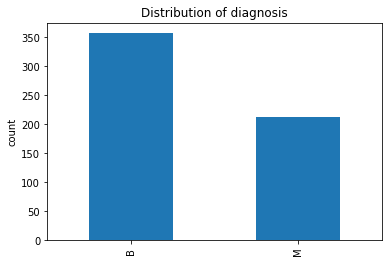

In [ ]:
print(wisc['diagnosis'].value_counts())

wisc['diagnosis'].value_counts().plot.bar()
plt.ylabel('count')
plt.title('Distribution of diagnosis')
plt.show()

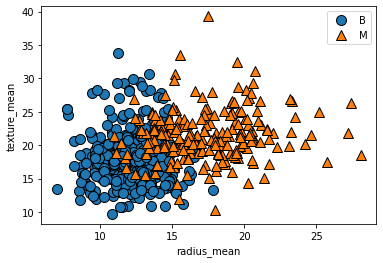

In [ ]:
mglearn.discrete_scatter(wisc['radius_mean'], wisc['texture_mean'], wisc['diagnosis'])
plt.xlabel("radius_mean")
plt.ylabel("texture_mean")
plt.legend()
plt.show()

## 의사결정나무 (Decision tree) 모델 

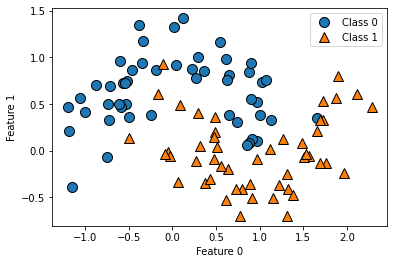

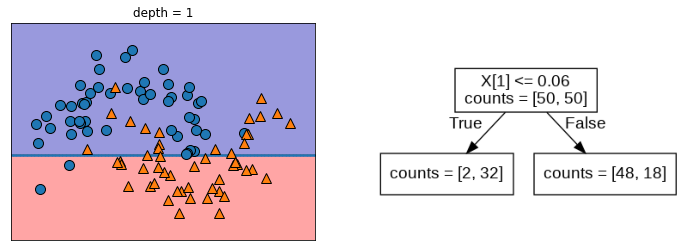

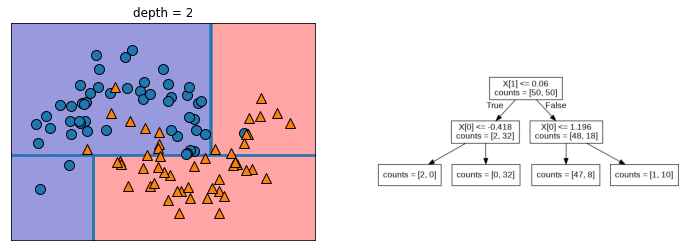

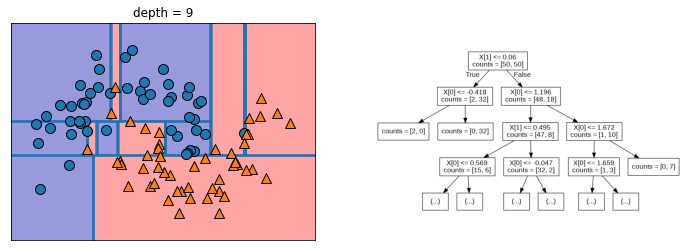

In [ ]:
# 의사결정나무 만드는 과정 
mglearn.plots.plot_tree_progressive()

### DecisionTreeClassifier

의사결정나무 모델 생성시 이용되는 주요 파라미터 
- criterion: 분할시 순수도 계산 방법 (gini, entropy, default: gini)
- splitter: 각 노드에서 분할을 선택하는 데 사용되는 전략 (best, random, default: best)
- max_depth: 나무의 최대 깊이 (default: none, 제한 없음) 
- min_samples_split: 자식 노드를 분할하는데 필요한 최소 샘플 수 (default: 2)
- min_samples_leaf: 마지막 잎 노드에 있어야 할 최소 샘플 수 (default: 1)
- max_features: 각 노드에서 분할에 사용할 변수의 최대 수 (auto, sqrt, log2, default: None)
- random_state: 난수 seed 설정 (max_features 만큼의 변수 선택시)
- max_leaf_nodes: 잎 노드의 최대수 (default: none)

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X = wisc.iloc[:, 1:]  # 30개 변수 
y = wisc.iloc[:, 0]   # target 변수 diagnosis 

# 데이터셋을 학습(train)과 테스트(test) 세트로 분할
# random_state : random 으로 분할시 사용되는 난수 seed 숫자
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

tree = DecisionTreeClassifier(random_state=0)  
tree.fit(X_train, y_train)
print("학습용 데이터 정확도: {:.3f}".format(tree.score(X_train, y_train)))
print("시험용 데이터 정확도: {:.3f}".format(tree.score(X_test, y_test)))

학습용 데이터 정확도: 1.000
시험용 데이터 정확도: 0.937


In [ ]:
# 의사결정나무의 깊이를 4로 제한하면 시험용 데이터에 대한 성능이 향상됨 (과적합을 줄임)
# 과적합(overfitting): 학습용 데이터에 대해서만 성능이 좋고 새로운 데이터에 적용했을 경우에는 성능이 좋지 않은 경우
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)

print("학습용 데이터 정확도: {:.3f}".format(tree.score(X_train, y_train)))
print("시험용 데이터 정확도: {:.3f}".format(tree.score(X_test, y_test)))

학습용 데이터 정확도: 0.988
시험용 데이터 정확도: 0.958


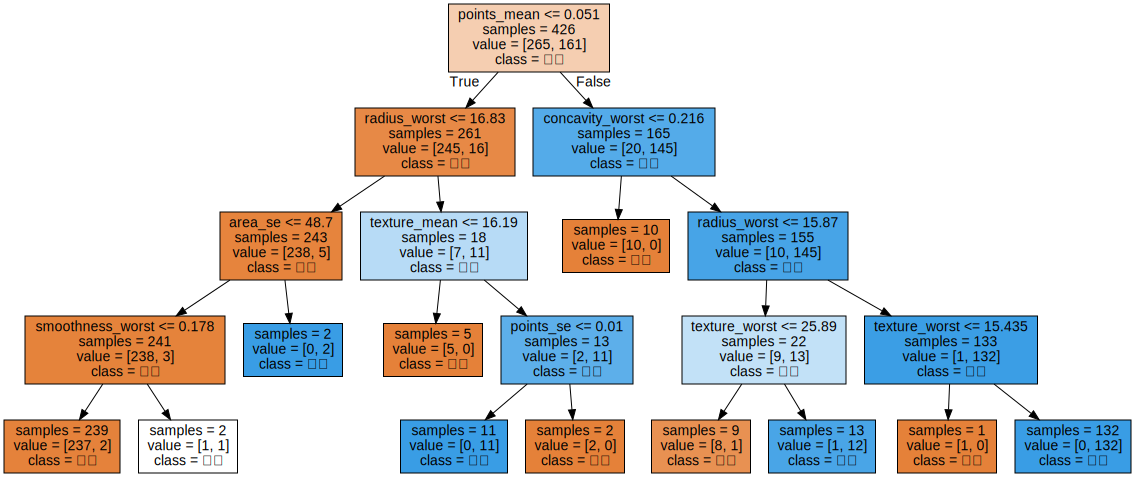

In [ ]:
#graphviz 라이브러리를 이용하여 의사결정나무 그리기 
from sklearn.tree import export_graphviz
import graphviz

# filled = True: 색상의 진하기로 클래스를 나타냄, impurity: 불순도 계산값 보여주기 옵션
export_graphviz(tree, out_file="tree.dot", class_names=[ "양성", "악성"],
                feature_names=wisc.columns[1:], impurity=False, filled=True)

with open("tree.dot") as f:
    dot_graph = f.read()

display(graphviz.Source(dot_graph))

### 주요 변수들 (features)
- 의사결정나무를 생성하는데 비중이 큰 변수들을 찾을 수 있지만, feature importance가 낮다고 하여 그 변수가 중요하지 않다는 것은 아님 (이 나무에서 그 변수가 사용되지 않았을 뿐 다른 변수가 동일한 정보를 지니고 있어서일 수도 있음)  
- 의사결정나무를 생성하는데 중요도가 높다는 것은 알 수 있지만, 양성을 지지하는지 악성을 지지하는지는 알 수 없음 

In [ ]:
result = tree.feature_importances_
print("변수의 중요도:\n", result)

변수의 중요도:
 [0.         0.02697206 0.         0.         0.         0.
 0.         0.70477293 0.         0.         0.         0.
 0.         0.02018065 0.         0.         0.         0.01765444
 0.         0.         0.09272565 0.04693116 0.         0.
 0.0050011  0.         0.08576201 0.         0.         0.        ]


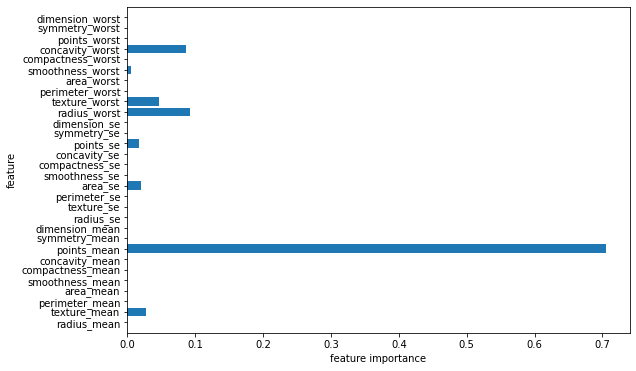

In [ ]:
import numpy as np

def plot_feature_importances_wisc(model):
    plt.rcParams["figure.figsize"] = (9,6)
    n_features = len(wisc.columns[1:])  # 30개 
    plt.barh(np.arange(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), wisc.columns[1:])   # 30개의 눈금을 표시하고 눈금 레이블을 변수 이름으로 지정
    plt.xlabel("feature importance")
    plt.ylabel("feature")
    plt.ylim(-1, n_features) #Y 축 범위 지정 (-1 ~ 30)

plot_feature_importances_wisc(tree)

In [ ]:
res = pd.DataFrame(result)
res["name"] = wisc.columns[1:]
display(res.info())

# perimeter_worst의 비중이 가장 큼, 루트 노드에서 이 값부터 사용 
display(res.sort_values(by='name'))  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       30 non-null     float64
 1   name    30 non-null     object 
dtypes: float64(1), object(1)
memory usage: 608.0+ bytes


None

,0,name
3,0.000000,area_mean
13,0.020181,area_se
23,0.000000,area_worst
5,0.000000,compactness_mean
15,0.000000,compactness_se
25,0.000000,compactness_worst
6,0.000000,concavity_mean
16,0.000000,concavity_se
26,0.085762,concavity_worst
9,0.000000,dimension_mean


### 의사결정나무 모델의 장단점  

- 모델의 시각화가 직관적이어서 설명하기에 좋다.
- 데이터의 스케일에 영향을 받지 않으므로 정규화나 전처리가 필요없다.
- 변수의 데이터 타입이 이진(binary)이나 연속값, 또는 이들이 혼합되어 있어도 잘 동작한다.
- 단점은 사전 가지치기 (예. 나무의 깊이 줄이기)를 사용해도 과적합되는 경향이 있다.  
 **-> 이를 해결하기 위해서 단일 의사결정나무 대신 앙상블 방법 사용**

## 앙상블 (Ensemble) 모델
여러 모델을 연결하여 더 강력한 모델을 만드는 기법으로, 다양한 앙상블 모델 중 의사결정나무를 기반으로 하는 랜덤 포레스트와 그래디언트 부스팅을 사용해 보자. 

- 랜덤 포레스트 (Random forest)
- 그래디언트 부스팅 (Gradient boosting)
- 그 외: 배깅(bagging), 엑스트라 트리, 에이다 부스팅 (Adaboost) 등 

###랜덤 포레스트 (Random forest)
- 의사결정나무를 '랜덤하게' 여러가지로 만들고 이들의 평균을 취하는 방법으로 과적합 문제를 완화시킬 수 있다. 
- 랜덤한 속성을 찾는 방법으로
 * 샘플을 임의로 취하거나 
 * 변수(feature)를 임의로 취한다.
- 평균을 구할 전체 나무의 숫자를 정해준다. (n_estimators)
- 샘플 데이터를 랜덤하게 취하기 위해서 부트스트랩 (Bootstrapping) 샘플링을 한다. (같은 수의 샘플을 취하되 중복 샘플링을 허용하는 방법). 샘플수가 100개면 한번도 샘플링 되지 않는 샘플수가 약 36%정도 된다.
- 몇 개의 변수(feature)를 사용할지도 지정한다. (max_features)
- 변수를 선택하는 작업은 각 노드에서 반복되므로 노드마다 "랜덤하게" 다른 변수를 사용하게 된다.
- 분류의 경우는 확률을 고려한 약한 투표를 하고 (대표값 하나만 투표하지 않고 여러 가능성의 가중평균을 구함), 회귀분석의 경우에는 앙상블의 평균치를 구한다.  

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


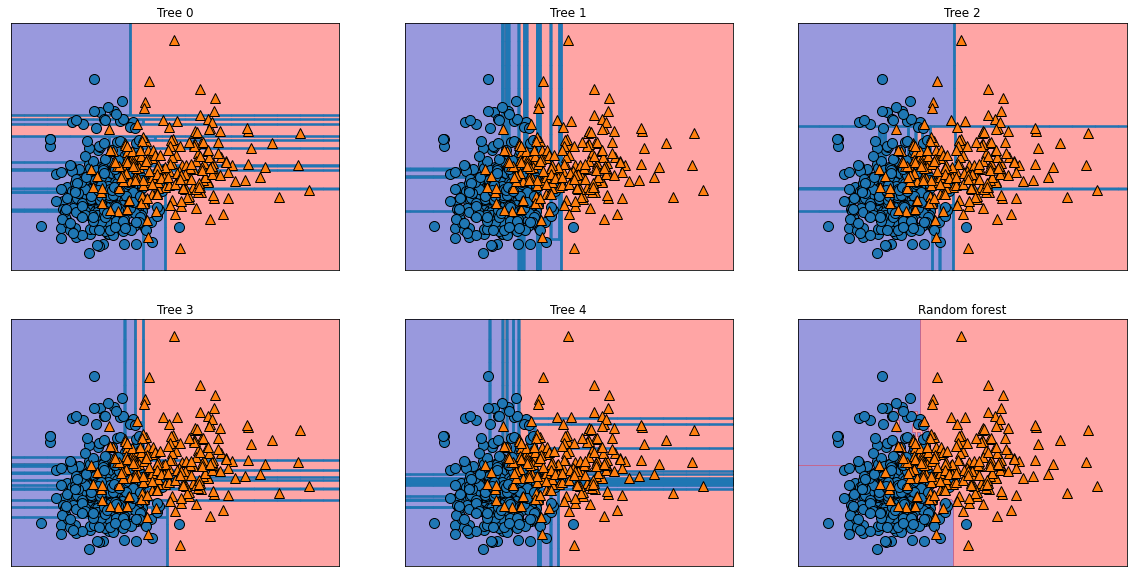

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# radius_mean, texture_mean 변수만 이용하여 
# 5개의 나무를 만드는 예 (n_estimators = 5, 실제는 수백개의 트리를 만든다)
forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train.iloc[:, 0:2], y_train)

# 5개 나무 각각의 분류 경계를 그림 (서로 모양이 많이 다르다)
# 2차원으로 나무의 결과를 보여주기 위한 코드로 mglearn의 함수들을 이용 - 여기서는 설명 생략
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(X.iloc[:, 0:2].values, y, tree, ax=ax)
    
mglearn.plots.plot_2d_separator(forest, X.iloc[:, 0:2].values, fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("Random forest")
mglearn.discrete_scatter(X.iloc[:, 0], X.iloc[:, 1], y)
plt.show()

In [ ]:
# 30개 변수를 모두 이용하여 100개의 나무 생성 (정확도가 높아짐)

forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

print("학습용 데이터 세트 정확도: {:.3f}".format(forest.score(X_train, y_train)))
print("시험용 데이터 세트 정확도: {:.3f}".format(forest.score(X_test, y_test)))

학습용 데이터 세트 정확도: 1.000
시험용 데이터 세트 정확도: 0.965


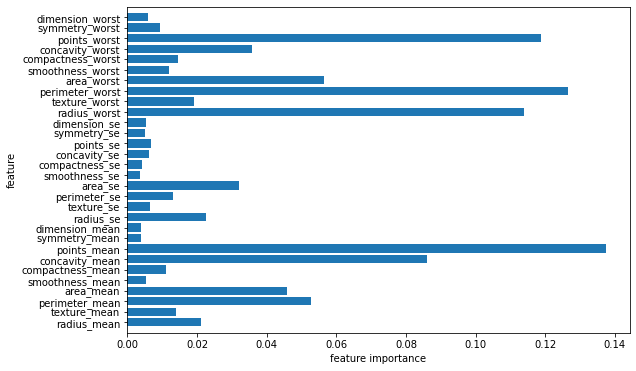

In [ ]:
# 단일 의사결정나무의 경우보다 많은 변수(feature)들이 사용됨
plot_feature_importances_wisc(forest)

랜덤 포레스트와 단일 의사결정나무 비교 
- 라인 차트를 그려봄으로써 랜덤포레스트가 의사결정트리보다 매번 정확도가 높은 것을 확인할 수 있다.

In [ ]:
from sklearn.model_selection import cross_val_score

# 교차 검증을 10번 수행하여 10번의 교차 검증 평균 정확도를 비교 (10-fold cross validation)
# default cv=5

dt_scores = cross_val_score(tree, X_train, y_train, cv=10, scoring='accuracy')  
rf_scores = cross_val_score(forest, X_train, y_train, cv=10, scoring='accuracy')

print("Accuracy")
print("Decision tree: ", dt_scores) 
print("Random forest: ", rf_scores) 

print("Accuracy mean")
print("Decision tree :{:.3f}".format(dt_scores.mean())) 
print("Random forest :{:.3f}".format(rf_scores.mean())) 

Accuracy
Decision tree:  [0.90697674 0.8372093  0.86046512 0.95348837 0.90697674 0.97674419
 0.92857143 0.85714286 0.92857143 0.95238095]
Random forest:  [0.97674419 0.93023256 0.88372093 0.97674419 0.97674419 0.97674419
 0.95238095 0.92857143 0.95238095 1.        ]
Accuracy mean
Decision tree :0.911
Random forest :0.955


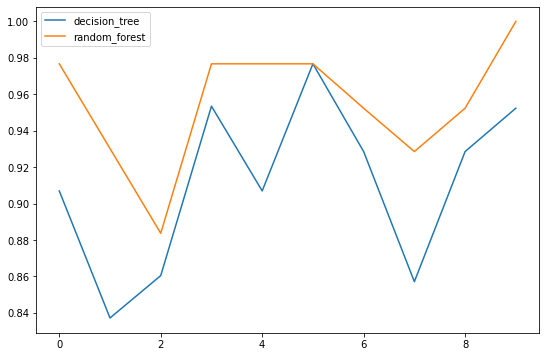

In [ ]:
cv_list = [    
            ['decision_tree',dt_scores],
            ['random_forest',rf_scores],
          ]
df = pd.DataFrame.from_dict(dict(cv_list))
df.plot()

랜덤 포레스트의 장단점
- 성능이 매우 뛰어나고 매개변수 튜닝을 많이 하지 않아도 잘 작동한다. 
- 대량의 데이터는 여러개의 CPU에 나누어 손쉽게 병렬처리할 수 있다. (n_jobs=-1) 
- n_estimator(나무의 수)는 클수록 성능은 좋아지나 훈련 시간은 오래 걸릴 수 있다. 
- 랜덤하므로 결과 모델이 매번 달라질 수 있다
- 텍스트 데이터처럼 차원이 높고 희소한 데이터에는 잘 동작하지 않는다. (선형모델이 더 적합)
- max_features는 일반적으로 기본값을 쓰는 것이 좋다.(분류에서는 sqrt(n_features), 회귀에서는 n_features)

###그래디언트 부스팅 (Gradient Boosting)

- 랜덤한 방식으로 트리의 앙상블을 구하는 것이 아니라 이전의 트리의 성능을 단계적으로 보완하여 오차를 줄이는 방식으로 나무를 생성한다. 
- 보통 1~5 정도의 깊지 않은 나무 (약한 학습기, weak learner)를 사용함으로써 학습 속도가 빠르다. 
- 이전 나무의 오차를 얼마나 강하게 보정할 것인지를 제어하는 학습속도(learning rate)를 미세하게 조정해주어야 한다.
- 가장 성능이 좋은 알고리즘으로 분류 및 예측에 모두 사용된다.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
# 기본값은 max_depth= 3, n_estimators=100, learning_rate = 0.1

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

In [ ]:
print("학습용 데이터 세트 정확도: {:.3f}".format(gbrt.score(X_train, y_train)))
print("시험용 데이터 세트 정확도: {:.3f}".format(gbrt.score(X_test, y_test)))

학습용 데이터 세트 정확도: 1.000
시험용 데이터 세트 정확도: 0.965


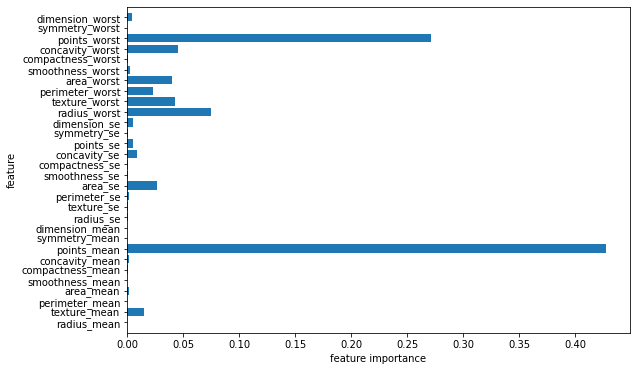

In [ ]:
plot_feature_importances_wisc(gbrt)

- 학습용 데이터 세트의 정확도가 100%이므로 과적합임
- 과적합을 막기 위해서 나무의 최대 깊이를 줄여 사전 가지치기를 강하게 하거나 학습률을 낮출 수 있음
- 아래 예에서는 시험용 데이터 세트의 정확도가 이미 최대치라 더이상 향상되지는 않음

In [ ]:
#나무 깊이 제한
gbrt = GradientBoostingClassifier(random_state=0, max_depth=2)
gbrt.fit(X_train, y_train)

print("학습 데이터 세트 정확도: {:.3f}".format(gbrt.score(X_train, y_train)))
print("시험용 데이터 세트 정확도: {:.3f}".format(gbrt.score(X_test, y_test)))

학습 데이터 세트 정확도: 1.000
시험용 데이터 세트 정확도: 0.965


In [ ]:
#학습률 감소
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)

print("학습 데이터 세트 정확도: {:.3f}".format(gbrt.score(X_train, y_train)))
print("시험용 데이터 세트 정확도: {:.3f}".format(gbrt.score(X_test, y_test)))

학습 데이터 세트 정확도: 0.991
시험용 데이터 세트 정확도: 0.965


그래디언트 부스팅의 장단점
- 기본적으로는 더 안정적인 랜덤 포레스트를 사용하고, 성능 향상과 예측 시간이 중요한 경우에는 정교하게 그래디언트 부스팅 방식을 사용한다.
- 이전 나무의 오차를 보정하는 학습 속도(learning_rate)를 낮추면 비슷한 복잡도의 모델을 만들기 위해 보통 더 많은 트리를 사용해야 한다.
- 랜덤 포레스트에서는 n_estimator(나무의 수)가 클수록 성능이 개선되나 그래디언트 부스팅에서는 과적합될 수 있다.
- 먼저 가용한 자원 범위에서 나무의 수를 정하고, 학습 속도를 튜닝한다.
- 나무의 깊이(max_depth)는 보통 5 이하를 사용한다.
- 희소한 고차원 데이터에 대해서는 잘 동작하지 않는다.

XGBoost, LightGBM, CatBoost 
- 대규모 데이터를 사용할 경우에는 분산 컴퓨팅을 활용하는 확장성이 뛰어난 XGBoost (eXtreme Gradient Boosting) 를 이용하는 것이 효과적이다.(kaggle 경연대회에서 사용되는 가장 성능이 좋은 기법임)
- 이외에도 LightGBM (Light Gradient Boosting Methods, XGBoost보다 학습에 걸리는 시간과 메모리 사용량이 적음), CatBoost (Categorical Boosting, 범주형 변수가 많은 데이터셋에서 예측 성능이 우수함)을 사용할 수 있다. 

# 분류 모델 평가 (Evaluation)


## 교차 검증 (Cross validation)

* 최적의 모델(파라미터 선택)을 찾기 위해서는 학습용 데이터(train dataset)를 모델 학습을 위한 데이터와 모델 검증을 위한 데이터로 나누어야 한다.  
* 데이터를 무작위로 한 번만 나누게 되면 분류하기 쉬운 데이터만 학습에 이용될 수도 있고, 반대로 분류하기 어려운 데이터로만 이용할 수도 있다. 학습용 데이터를 나누는 방법에 따라 모델의 정확도 결과가 달라지기 때문에 선택되는 최적의 모델 또한 달라지게 된다.  
* 따라서, 학습용 데이터를 k개 fold로 나눈 후, k-1 folds는 학습에 이용하고 1 fold는 모델 검증에 이용한다. 검증에 사용하는 데이터를 선택하는 방법이 k개 있으므로, k번 검증하고 k개 결과값의 평균을 사용하여 평가한다.   
* 교차 검증은 k가 클수록 연산비용은 늘어나지만, 특정 데이터에만 과적합되는 모델을 만들게 되는 문제를 해결할 있으며 모든 데이터에 일반화가 잘 되었는지 평가할 수 있다.  



In [ ]:
# 교차 검증을 10번 수행하여 10번의 교차 검증 평균 정확도를 비교 (10-fold cross validation)
# default cv=5

dt_scores = cross_val_score(tree, X_train, y_train, cv=10, scoring='accuracy')  
rf_scores = cross_val_score(forest, X_train, y_train, cv=10, scoring='accuracy')
gbrt_scores = cross_val_score(gbrt, X_train, y_train, cv=10, scoring='accuracy')

print("Accuracy")
print("Decision tree: ", dt_scores) 
print("Random forest: ", rf_scores) 
print("Gradient boosting: ", gbrt_scores) 

print("Accuracy mean")
print("Decision tree :{:.3f}".format(dt_scores.mean())) 
print("Random forest :{:.3f}".format(rf_scores.mean())) 
print("Gradient boosting :{:.3f}".format(gbrt_scores.mean())) 

Accuracy
Decision tree:  [0.90697674 0.8372093  0.86046512 0.95348837 0.90697674 0.97674419
 0.92857143 0.85714286 0.92857143 0.95238095]
Random forest:  [0.97674419 0.93023256 0.88372093 0.97674419 0.97674419 0.97674419
 0.95238095 0.92857143 0.95238095 1.        ]
Gradient boosting:  [1.         0.93023256 0.8372093  0.93023256 0.95348837 0.95348837
 0.9047619  0.95238095 0.95238095 1.        ]
Accuracy mean
Decision tree :0.911
Random forest :0.955
Gradient boosting :0.941


In [ ]:
# 교차 검증 상세 옵션 지정

# KFold :기본값 n_splits=5, shuffle=None (데이터를 임의로 섞지 않음) 
# LeaveOneOut :데이터 1개를 검증에 이용 
# ShuffleSplit :임의 분할, 전체 데이터를 모두 사용하지 않을 수도 있음
# GroupKFold :그룹을 지정해서 같은 그룹의 데이터는 학습용 또는 검증용으로 동일하게 분할
# StratifiedKFold :각 fold마다 클래스의 분포가 동일하도록 분할 (예. 악성:양성) 
# RepeatedStratifiedKFold: 교차검증을 반복, 기본값 n_repeats =10

from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=10)
#from sklearn.model_selection import RepeatedStratifiedKFold
#kf = RepeatedStratifiedKFold(n_splits=10)

print(kf)

dt_scores = cross_val_score(tree, X_train, y_train, cv=kf, scoring='accuracy')  
rf_scores = cross_val_score(forest, X_train, y_train, cv=kf, scoring='accuracy')
gbrt_scores = cross_val_score(gbrt, X_train, y_train, cv=kf, scoring='accuracy')

print("Accuracy mean -- StratifiedKFold 이용")
print("Decision tree :{:.3f}".format(dt_scores.mean())) 
print("Random forest :{:.3f}".format(rf_scores.mean())) 
print("Gradient boosting :{:.3f}".format(gbrt_scores.mean())) 

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
Accuracy mean -- StratifiedKFold 이용
Decision tree :0.911
Random forest :0.955
Gradient boosting :0.941


## 그리드 서치 (Grid Search)

* 최고의 성능을 가지는 모델을 찾기 위해서는 여러 파라미터들을 변경해 보면서 최적의 조합을 찾아야 한다. 
* GridSearchCV를 이용하여 그래디언트 부스팅 모델의 max_depth, learning_rate 값을 순차적으로 변경하면서 최적화를 수행할 수 있다. 

In [ ]:
from sklearn.model_selection import GridSearchCV

# 파라미터를 dictionary 형태로 설정
parameters = {'max_depth':[1,2,3], 'learning_rate':[0.1,0.08, 0.06, 0.04, 0.02]}

In [ ]:
# param_grid의 파라미터들을 3개의 fold 로 나누어 검증
# refit=True (기본값): 가장 좋은 파라미터 설정으로 재학습  
init_gbrt = GradientBoostingClassifier(random_state=0)
grid_gbrt = GridSearchCV(init_gbrt, param_grid=parameters, cv=3, refit=True)
print(grid_gbrt)
# 파라미터들을 순차적으로 학습, 검증
grid_gbrt.fit(X_train, y_train)

# GridSearchCV 결과 추출하여 DataFrame으로 변환
scores_df = pd.DataFrame(grid_gbrt.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score']]

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=0),
             param_grid={'learning_rate': [0.1, 0.08, 0.06, 0.04, 0.02],
                         'max_depth': [1, 2, 3]})


,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'learning_rate': 0.1, 'max_depth': 1}",0.941315,6,0.936620,0.936620,0.950704
1,"{'learning_rate': 0.1, 'max_depth': 2}",0.943662,3,0.943662,0.943662,0.943662
2,"{'learning_rate': 0.1, 'max_depth': 3}",0.948357,2,0.957746,0.950704,0.936620
3,"{'learning_rate': 0.08, 'max_depth': 1}",0.938967,8,0.936620,0.943662,0.936620
4,"{'learning_rate': 0.08, 'max_depth': 2}",0.943662,3,0.943662,0.943662,0.943662
5,"{'learning_rate': 0.08, 'max_depth': 3}",0.953052,1,0.950704,0.950704,0.957746
6,"{'learning_rate': 0.06, 'max_depth': 1}",0.938967,8,0.936620,0.943662,0.936620
7,"{'learning_rate': 0.06, 'max_depth': 2}",0.943662,3,0.950704,0.936620,0.943662
8,"{'learning_rate': 0.06, 'max_depth': 3}",0.938967,8,0.929577,0.943662,0.943662
9,"{'learning_rate': 0.04, 'max_depth': 1}",0.934272,13,0.929577,0.943662,0.929577


In [ ]:
print('GridSearchCV 최적 파라미터:', grid_gbrt.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_gbrt.best_score_))

GridSearchCV 최적 파라미터: {'learning_rate': 0.08, 'max_depth': 3}
GridSearchCV 최고 정확도: 0.9531


In [ ]:
# 최적 파라미터로 학습이 된 모델을 이용하여 시험용 데이터 세트 분류
print("시험용 데이터 세트 정확도: {:.3f}".format(grid_gbrt.score(X_test, y_test)))

시험용 데이터 세트 정확도: 0.965


## 모델 평가 지표

* 정오 분류표(Confusion matrix)
* 정확도(accuracy), 민감도(sensitivity), 특이도(specificity), 정밀도(precistion), 재현률(recall), F1-measure
* ROC (Receiver Operator Characteristic) 곡선과 AUC (Aread Under the Curve)

### 정오 분류표 (Confusion matrix)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix 

print(y_test.value_counts()) # y_test 의 B,M 분포

dt_pred = tree.predict(X_test)
rf_pred = forest.predict(X_test)
grid_gbrt_pred = grid_gbrt.predict(X_test)

# 예측 결과인 pred와 실제 결과인 y_test의 Confusion Matrix 출력
print('Decision tree 시험용 데이터 세트 정확도:{:.3f}'.format(accuracy_score(y_test, dt_pred)))
print(confusion_matrix(y_test, dt_pred))
print('Random forest 시험용 데이터 세트 정확도:{:.3f}'.format(accuracy_score(y_test, rf_pred)))
print(confusion_matrix(y_test, rf_pred))
print('Gradient boosting 시험용 데이터 세트 정확도:{:.3f}'.format(accuracy_score(y_test, grid_gbrt_pred)))
print(confusion_matrix(y_test, grid_gbrt_pred))

B    92
M    51
Name: diagnosis, dtype: int64
Decision tree 시험용 데이터 세트 정확도:0.958
[[89  3]
 [ 3 48]]
Random forest 시험용 데이터 세트 정확도:0.965
[[89  3]
 [ 2 49]]
Gradient boosting 시험용 데이터 세트 정확도:0.965
[[89  3]
 [ 2 49]]


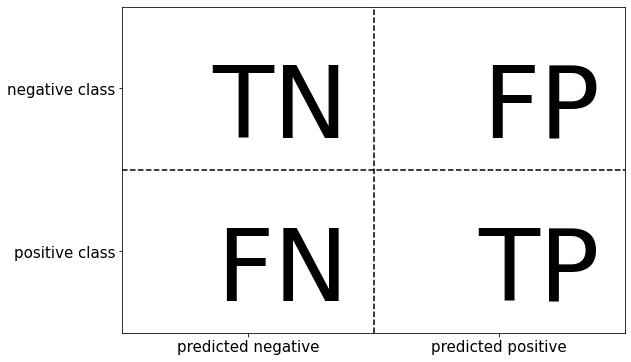

In [ ]:
mglearn.plots.plot_binary_confusion_matrix()

* 정밀도(precision = TP/(TP+FP))가 상대적으로 더 중요한 지표인 경우는 실제로 Negative인 데이터 예측을 Postive로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우  
  * **스팸 메일 여부 판단:** 실제 Positive 인 스팸 메일을 Negative 인 일반 메일로 분류하더라도 사용자가 불편함을 느끼는 정도이지만, 실제 Negative인 일반 메일을 Positive인 스팸 메일로 분류할 경우 메일을 아예 받지 못하게 되어 업무에 차질이 생김
  * **임상 실험을 통한 신약 치료 효과 예측:** 임상 실험은 비용이 많이 들기 때문에 단 한 번의 실험으로 신약 효과를 검증하기를 원함. 따라서 실제로 Negative인데 Positive로 예측하는 경우를 많이 만들지 않는 것이 중요함   

* 재현율(recall = sensitivity =  TP/(TP+FN))이 상대적으로 더 중요한 지표인 경우는 실제로 Positive인 데이터 예측을 Negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우  
  * **암 판단 모델:** 실제 Positive 인 암 환자를 Negative 음성으로 잘못 판단할 경우 오류의 대가가 생명을 앗아갈 정도록 심각함. 실제 Negative인 건강한 환자를 암환자인 Positive로 예측한 경우면 다시 한번 재검사를 하는 수준의 비용이 소모될 것임

* 정밀도와 재현율은 상호 보완적인 평가 지표로 어느 한 쪽을 강제로 높이면 다른 하나의 수치는 떨어짐 (trade-off)  
* 정밀도와 재현율의 맹점 - 두 수치를 상호 보완할 수 있는 f1-measure 필요 
  * 확실히 Positive의 징후를 가진 환자가 단 1명이라고 할때 이 한 명만 Positive 로 예측하고, 나머지는 모두 Negative로 예측하더라도 FP =0, TP = 1이 되므로, 정밀도는 1/(1+0) = 100%가 됨
  * 전체 환자 1000명 중 Positive인 환자가 30명일때, 모든 환자를 Positive로 예측하면 FN = 0, TP = 30 이므로 재현율은 30/(30+0) = 100%가 됨


In [ ]:
print('정밀도:{:.3f}'.format(precision_score (y_test, grid_gbrt_pred, average='binary', pos_label="M")))  # pos_label = 1 기본값
print('TP (49) / TP+FP (52) = {:.3f}'.format(49/52))
print('재현율:{:.3f}'.format(recall_score(y_test, grid_gbrt_pred, average='binary', pos_label="M")))
print('TP (49) / TP+FN (51) = {:.3f}'.format(49/51))
print('f1-measure:{:.3f}'.format(f1_score(y_test, grid_gbrt_pred, average='binary', pos_label="M")))
print('2*(정밀도*재현율)/(정밀도+재현율) = {:.3f}'.format(2*0.942*0.961/(0.942+0.961)))

정밀도:0.942
TP (49) / TP+FP (52) = 0.942
재현율:0.961
TP (49) / TP+FN (51) = 0.961
f1-measure:0.951
2*(정밀도*재현율)/(정밀도+재현율) = 0.951


In [ ]:
from sklearn.metrics import classification_report

# 각 클래스가 Positive일 때의 정밀도, 재현율, f1 값을 보여줌 ("M"이 Postivit인 경우가 기본값임)
# macro avg는 클래스별 점수의 평균을 계산
# weighted avg는 클래스의 샘플 수로 가중평균을 계산
print("Decision Tree:")
print(classification_report(y_test, dt_pred, target_names=["B", "M"]))
print("Random Forest:")
print(classification_report(y_test, rf_pred, target_names=["B", "M"]))
print("Gradient Boosting:")
print(classification_report(y_test, grid_gbrt_pred, target_names=["B", "M"]))

Decision Tree:
              precision    recall  f1-score   support

           B       0.97      0.97      0.97        92
           M       0.94      0.94      0.94        51

    accuracy                           0.96       143
   macro avg       0.95      0.95      0.95       143
weighted avg       0.96      0.96      0.96       143

Random Forest:
              precision    recall  f1-score   support

           B       0.98      0.97      0.97        92
           M       0.94      0.96      0.95        51

    accuracy                           0.97       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.97      0.97      0.97       143

Gradient Boosting:
              precision    recall  f1-score   support

           B       0.98      0.97      0.97        92
           M       0.94      0.96      0.95        51

    accuracy                           0.97       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.97  

### ROC (Receiver Operator Characteristic) 곡선과 AUC (Area Under the Curve)

* 분류 기준값(cutoff)을 이용하여 민감도(sensitivity)와 특이도(specificity)를 조정할 수 있다. 
* 분류 예측의 확신 정도를 가늠하기 위한 함수    
  * 분류 모델에 따라서 결정함수 (decision_function: Positive 클래스에 속한다고 믿는 정도), 예측확률 함수 (pred_proba: 각 클래스에 대한 확률) 이용
  * 이진 분류에서 decision_function은 0을, predict_prob 는 0.5를 분류 기준값으로 사용 (분류 기준값보다 큰 경우를 Positive 클래스로 예측)
  * 대부분의(전체는 아니고) 분류 클래스는 적어도 둘 중 하나를 제공하고 두 함수를 모두 제공하는 경우도 많음

* ROC 곡선: 분류 기준값에 따른 민감도와 특이도의 관계를 도식화한 곡선  
  * y축: True Positive Rate (TPR)= 민감도 (Positive인 경우를 Positive로 예측하는 수준)
  * x축: False Positive Rate (FPR) = 1- 특이도 (Negative인 경우를 Negative로 예측하는 수준)


[[0.9916318  0.0083682 ]
 [0.07692308 0.92307692]
 [0.9916318  0.0083682 ]
 [0.         1.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.         1.        ]
 [0.9916318  0.0083682 ]
 [0.9916318  0.0083682 ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.9916318  0.0083682 ]
 [0.9916318  0.0083682 ]
 [0.9916318  0.0083682 ]
 [1.         0.        ]
 [0.9916318  0.0083682 ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.9916318  0.0083682 ]
 [0.         1.        ]
 [0.9916318  0.0083682 ]
 [0.9916318  0.0083682 ]
 [0.9916318  0.0083682 ]
 [0.9916318  0.0083682 ]
 [0.9916318  0.0083682 ]
 [0.9916318  0.0083682 ]
 [0.         1.        ]
 [0.88888889 0.11111111]
 [0.         1.        ]
 [0.9916318  0.0083682 ]
 [0.9916318  0.0083682 ]
 [0.9916318  0.0083682 ]


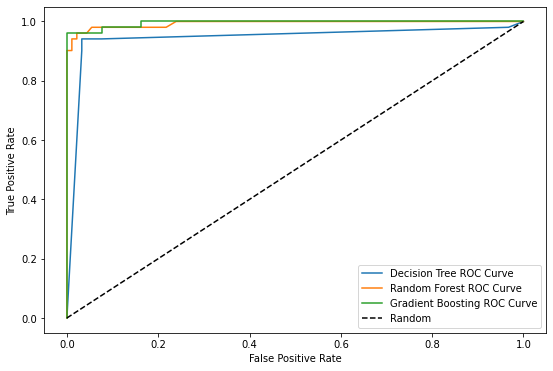

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

print(tree.predict_proba(X_test))

fpr_dt, tpr_dt, cutoff_dt = roc_curve(y_test, tree.predict_proba(X_test)[:, 1], pos_label="M")
fpr_rf, tpr_rf, cutoff_rf = roc_curve(y_test, forest.predict_proba(X_test)[:, 1], pos_label="M")
fpr_gbrt, tpr_gbrt, cutoff_gbrt = roc_curve(y_test, grid_gbrt.predict_proba(X_test)[:, 1], pos_label="M")

plt.plot(fpr_dt, tpr_dt, label="Decision Tree ROC Curve")
plt.plot(fpr_rf, tpr_rf, label="Random Forest ROC Curve")
plt.plot(fpr_gbrt, tpr_gbrt, label="Gradient Boosting ROC Curve")
plt.plot([0,1], [0, 1], "k--", label ="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc=4)
plt.show() 

In [ ]:
auc_dt = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])
auc_rf = roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])
auc_gbrt = roc_auc_score(y_test, grid_gbrt.predict_proba(X_test)[:, 1])
print("Decision Tree의 AUC: {:.3f}".format(auc_dt))
print("Random Forest의 AUC: {:.3f}".format(auc_rf))
print("Gradient Boosting의 AUC: {:.3f}".format(auc_gbrt)) ## AUC 면적이 가장 큰 모델

Decision Tree의 AUC: 0.944
Random Forest의 AUC: 0.994
Gradient Boosting의 AUC: 0.995
